In [479]:
# Base Imports
import pandas as pd
import matplotlib.pyplot as plt

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Others
from tabulate import tabulate
# Boxplot
import seaborn as sns

In [480]:
# load in the testing feature_df
feature_df = pd.read_csv('feature_df.csv')

# Fake News vs. Official Communication

### Preprocessing
Note that we do not include plausibility here. 

In [481]:
# Select relevant features
feature_df = feature_df[['source','preprocessed','label', 'interestingness', 'sentiment_BERT',
                          'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 
                          'sentiment_vader', 'readability', 'exclamation_marks', 'question_marks',
                          'digits', 'hashtags', 'lexical_diversity', 'superlatives', 'novelty', 
                          'average_word_length', 'plausibility']]

In [482]:
# 8 times ChatGPT assigned non-existant labels, exclude them 
print(feature_df.isna().sum())
print(len(feature_df))

source                 0
preprocessed           0
label                  0
interestingness        8
sentiment_BERT         0
sentiment_RoBERTa      0
concreteness           0
valence                0
dominance              0
arousal                0
sentiment_vader        0
readability            0
exclamation_marks      3
question_marks         3
digits                 3
hashtags               3
lexical_diversity      0
superlatives           0
novelty                0
average_word_length    0
plausibility           0
dtype: int64
28609


In [483]:
feature_df = feature_df.dropna()
len(feature_df)

28598

#### Testing Standardization and Normalization

In [484]:
# Define feature set and target variable
features = feature_df.columns.drop('label').drop('source').drop('preprocessed')
X = feature_df[features]
y = feature_df['label']

print(X)

       interestingness  sentiment_BERT  sentiment_RoBERTa  concreteness  \
0                  1.0               4                  1      0.652198   
1                  1.0               5                  1      0.642415   
2                  0.0               4                  1      0.647267   
3                  1.0               5                  1      0.646969   
4                  2.0               1                  1      0.644149   
...                ...             ...                ...           ...   
28604              1.0               4                  1      0.635142   
28605              1.0               2                  1      0.642401   
28606              1.0               5                  1      0.631691   
28607              1.0               4                  1      0.661529   
28608              0.0               4                  0      0.625324   

        valence  dominance   arousal  sentiment_vader  readability  \
0      0.606417   0.630947  0

In [485]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit the encoder and transform y
y = le.fit_transform(y)

In [486]:
# evaluate model function
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

def evaluate_model(X,y, model, cv):
    
    scoring = {'Accuracy': 'accuracy', 
                'Balance Accuracy': "balanced_accuracy", 
                'ROC AUC': 'roc_auc', 
                'PR AUC': 'average_precision'}

    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

    score_summary = []
    for key, value in scores.items():
        score_summary.append([key[5:], value.mean(), value.std()])

    # Use Tabulate to print a table
    print(tabulate(score_summary[2:], headers=["Metric", "Average", "STD"]), "\n")
    return score_summary

In [416]:
from sklearn.preprocessing import StandardScaler, Normalizer

# Initialize a StandardScaler and fit it to your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize a Normalizer and fit it to your data
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X)

In [417]:
# Create and fit the model
lsvc = LinearSVC(random_state=42)

evaluate_model(X, y, lsvc, cv)
evaluate_model(X_scaled, y, lsvc, cv)
evaluate_model(X_normalized, y, lsvc, cv)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.856423  0.0080947
Balance Accuracy   0.855758  0.00620989
ROC AUC            0.930078  0.00437347
PR AUC             0.918171  0.00584051 



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.857787  0.00364483
Balance Accuracy   0.857547  0.00360499
ROC AUC            0.931591  0.00379099
PR AUC             0.920775  0.00473406 

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.854675  0.00426
Balance Accuracy   0.853502  0.00449249
ROC AUC            0.923234  0.00355213
PR AUC             0.909884  0.00457716 



[['ime', 0.06679801940917969, 0.014183969409965918],
 ['_time', 0.005405426025390625, 0.0009030070619554072],
 ['Accuracy', 0.8546750434388132, 0.0042600017557378154],
 ['Balance Accuracy', 0.8535021539077802, 0.004492493079054846],
 ['ROC AUC', 0.9232341070196199, 0.0035521345172125013],
 ['PR AUC', 0.9098838307864044, 0.004577159659861199]]

In [487]:
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

#### Testing Plausibility Only

In [491]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Fit the model
lsvc.fit(X_train['plausibility'], y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test['plausibility'])

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ValueError: Expected 2D array, got 1D array instead:
array=[1. 0. 2. ... 2. 0. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [492]:
# Define feature set and target variable
features = feature_df.columns.drop('label').drop('source').drop('preprocessed').drop('plausibility')
X = feature_df[features]
y = feature_df['label']



In [493]:
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

### Baseline Models

#### Linear SVM

In [465]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Fit the model
lsvc.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test)

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.7993006993006992


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Logistic Regression

In [466]:
# Initialize the model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)

# Fit the model
logistic_model.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = logistic_model.predict(X_test)

# Print the accuracy score
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy:  0.7963286713286714


#### Random Forest

In [468]:
# Tree-baed model

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Use the fitted model to make predictions on the test data
y_pred = rf.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8636363636363636

Confusion Matrix:
 [[2808  365]
 [ 415 2132]]


In [469]:
# 86% is surprisingly high, does it hold over five folds? 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

evaluate_model(X_train, y_train, rf, cv)


Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.852784  0.00344011
Balance Accuracy   0.851028  0.00409576
ROC AUC            0.92755   0.0027091
PR AUC             0.905424  0.00312457 



[['ime', 2.897959899902344, 0.08442110388128728],
 ['_time', 0.13190174102783203, 0.005363226406413658],
 ['Accuracy', 0.8527842103251938, 0.003440112255303391],
 ['Balance Accuracy', 0.8510278885141602, 0.004095763110240258],
 ['ROC AUC', 0.9275501608621189, 0.0027090970633689066],
 ['PR AUC', 0.9054239271968513, 0.0031245704278247163]]

### Advanced Models


In [473]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt']  # number of features to consider at each split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_

# Print the best score
print("Best score: ", best_score)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.8527843342949559


In [475]:
# Make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Accuracy: 0.8671328671328671
Confusion Matrix:
[[2818  355]
 [ 405 2142]]


In [476]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define our XGBClassifier with default hyperparameters
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define our parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],  # commonly used values
    'max_depth': [3, 10],  # lower bound and upper bound
    'min_child_weight': [1, 5],  # lower bound and upper bound
    'gamma': [0, 0.2],  # default is 0, let's try adding some regularization
    'subsample': [0.5, 1.0],  # lower bound and upper bound
    'colsample_bytree': [0.6, 1.0]  # lower bound and upper bound
}

# Initialize GridSearchCV
grid_cv = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV
grid_cv.fit(X_train, y_train)

# Print best parameters and results
print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best score: {grid_cv.best_score_}")

# Apply model to test data
y_pred = grid_cv.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=

In [477]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.1, 10, 1000], 
              'gamma': [0.1, 0.001],
              'kernel': ['rbf', 'poly']}

# Create a SVC model
svc = SVC(probability=True, class_weight='balanced')

# Use Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(svc, param_grid, cv=cv, verbose=3, n_jobs=-1, scoring='f1_macro')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Use the best estimator for predictions
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.774 total time= 1.7min
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.771 total time= 1.7min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.773 total time= 1.7min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.778 total time= 1.7min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.772 total time= 1.8min
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.760 total time= 1.7min
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.762 total time= 1.8min
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.758 total time= 1.8min
[CV 1/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.471 total time= 1.3min
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.757 total time= 1.8min
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.757 total time= 1.7min
[CV 2/5] END ...C=0.1, gamma=0.001, kernel=poly;

KeyboardInterrupt: 

### Feature Importance

#### SFS Feature Selection

In [400]:
# Sequential backward selection
sbs = SFS(lsvc, 
           k_features=1, 
           forward=False, 
           floating=False, 
           scoring='accuracy',
           cv=5)

sbs = sbs.fit(X_train, y_train)

# Get the final set of features
final_features = list(sbs.k_feature_names_)
print('Final features:', final_features)

# So what is going on? 
for k in sbs.subsets_:
    print(f'Number of features: {k}')
    print('Selected features:', sbs.subsets_[k]['feature_names'])
    print('CV score:', sbs.subsets_[k]['avg_score'])
    print('-' * 50)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Final features: ['plausibility']


In [441]:
# Initialize a dictionary to hold feature names and the step at which they were removed
feature_elimination_steps = {}

# Start with the full feature set and move towards the smaller subsets
for i in range(len(X_train.columns), 0, -1):
    # Get the feature names for the current subset
    feature_subset = set(sbs.subsets_[i]['feature_names'])
    
    # If we're not at the last step yet
    if i > 1:
        # Get the feature names for the next smaller subset
        next_feature_subset = set(sbs.subsets_[i-1]['feature_names'])
        
        # Find the feature that was removed in the next step
        removed_feature = list(feature_subset - next_feature_subset)[0]
        
        # Record the step at which this feature was removed
        feature_elimination_steps[removed_feature] = len(X_train.columns) - i + 1

# The feature left at the last step is the most important one
most_important_feature = list(sbs.subsets_[1]['feature_names'])[0]
feature_elimination_steps[most_important_feature] = len(X_train.columns)

# Convert the dictionary to a DataFrame
feature_ranks = pd.DataFrame(list(feature_elimination_steps.items()), columns=['Feature', 'Rank'])

# Sort the DataFrame by rank in ascending order
feature_ranks = feature_ranks.sort_values('Rank', ascending=True)


In [226]:
import ast
import numpy as np 

# Find indices where predictions and actual values don't match
mismatched_indices = np.where(y_test != y_pred)[0]

# Now print some of these instances
num_mismatched_to_display = 10  # You can change this number to what suits you

# This function takes a string representation of list and returns an actual list
def string_to_list(list_string):
    return ast.literal_eval(list_string)

# Now apply this function to every cell in 'preprocessed' column to convert string representation of lists to actual lists
feature_df['preprocessed'] = feature_df['preprocessed'].apply(string_to_list)

for idx in mismatched_indices[:num_mismatched_to_display]:
    original_idx = y_test.index[idx]  # find original index from X_test
    print("Original tweet: ", ' '.join(feature_df.loc[original_idx, 'preprocessed']))  # print original tweet
    print("True class: ", y_test.iloc[idx])  # print true class
    print("Predicted class: ", y_pred[idx])  # print predicted class
    print("-"*50)  # print separator for clarity


Original tweet:  the report shows that in deaths remain unregistered this highlights the urgent need for investments to strengthen health information systems in all countries to support the covid19 response recovery progress towards healthforall
True class:  -1
Predicted class:  1
--------------------------------------------------
Original tweet:  aside from washing your hands frequently use betadine sore throat gargle to eliminate or minimise the germs while they are still in your throat before dripping down to your lungsconfusion
True class:  1
Predicted class:  -1
--------------------------------------------------
Original tweet:  i believe in the vaccine and trust the science and health care professionals im still wearing a mask because i dont want anyone who is at risk for covid or not fully vaccinated to feel uncomfortable around me especially at work
True class:  1
Predicted class:  -1
--------------------------------------------------
Original tweet:  including violence against

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_48892/3917376946.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['preprocessed'] = feature_df['preprocessed'].apply(string_to_list)


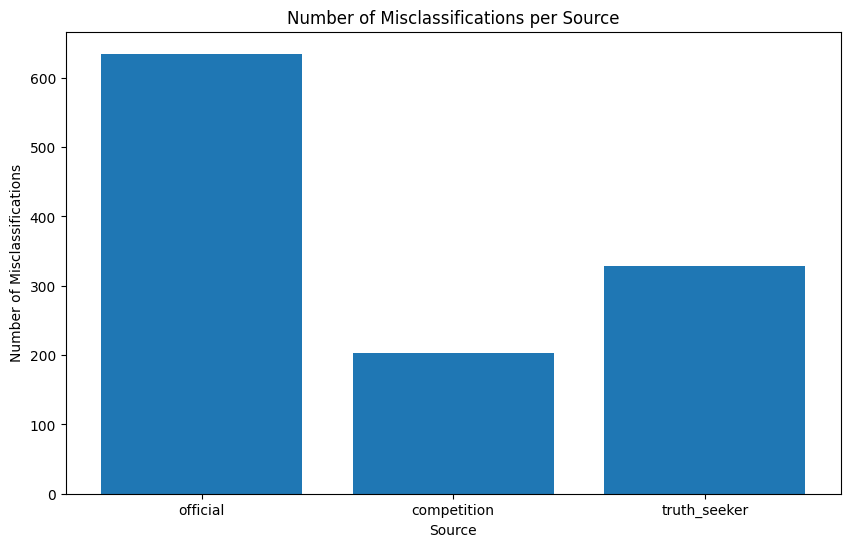

In [221]:
from collections import defaultdict

# Initialize a default dictionary
mismatched_source_counts = defaultdict(int)

# Iterate over mismatched indices
for idx in mismatched_indices:
    original_idx = y_test.index[idx]  # find original index from y_test
    source = feature_df.loc[original_idx, 'source']  # obtain original source
    mismatched_source_counts[source] += 1  # increment the count of this source

# Now let's plot the results
sources = list(mismatched_source_counts.keys())
counts = list(mismatched_source_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(sources, counts)
plt.xlabel('Source')
plt.ylabel('Number of Misclassifications')
plt.title('Number of Misclassifications per Source')
plt.show()

#### Select K Best

SelectKBest is a simple and effective way to perform univariate feature selection in sklearn. It's useful for datasets with many features where you want to reduce the dimensionality by keeping only the most informative features according to a specific criteria

It's important to keep in mind, however, that this method considers each feature individually, 
and so may miss out on important interactions between features.

In [327]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply the SelectKBest feature selection
fs = SelectKBest(score_func=f_classif, k=15)
X_selected = fs.fit_transform(X, y)

# Get the scores
scores = fs.scores_

# Get the feature names
feature_names = X.columns

# Create a DataFrame with feature names and their corresponding scores
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort the DataFrame by Score in descending order and reset the index
feature_scores = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_scores)


                Feature         Score
0          plausibility  17881.154919
1        sentiment_BERT  10743.958771
2     sentiment_RoBERTa   9874.209741
3               valence   4929.978366
4             dominance   4014.326707
5       sentiment_vader   3772.380269
6               novelty   3054.604432
7               arousal   2743.596436
8   average_word_length    521.701382
9          superlatives    410.126584
10          readability    397.893894
11      interestingness    303.073407
12    lexical_diversity     81.616264
13             hashtags      3.272741
14               digits      0.883027
15         concreteness      0.454960
16    exclamation_marks      0.299366
17       question_marks      0.196501


#### Random Forest Selection

In [331]:
# Get feature importances
importances = rf.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X_train.columns, importances)]

# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse=True)

# Print feature importances
for feature, importance in feature_importances_sorted:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: plausibility, Importance: 0.2841511196051837
Feature: sentiment_RoBERTa, Importance: 0.1112363349692759
Feature: sentiment_BERT, Importance: 0.09074364967945557
Feature: valence, Importance: 0.07055664736947435
Feature: concreteness, Importance: 0.05867095821317775
Feature: sentiment_vader, Importance: 0.0570593374000934
Feature: dominance, Importance: 0.05585261278119335
Feature: average_word_length, Importance: 0.05010689976446867
Feature: arousal, Importance: 0.04892586109235639
Feature: readability, Importance: 0.03959963025283276
Feature: lexical_diversity, Importance: 0.038465259407803314
Feature: novelty, Importance: 0.03654112888704859
Feature: digits, Importance: 0.019248264013867044
Feature: interestingness, Importance: 0.012478215398751127
Feature: hashtags, Importance: 0.011057704520919854
Feature: superlatives, Importance: 0.007088301863417781
Feature: question_marks, Importance: 0.004647690038196662
Feature: exclamation_marks, Importance: 0.0035703847424838025


#### Permutation Feature Importance


In [495]:
# Fit model with final features and get accuracy
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [496]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Assuming clf is your trained classifier
result = permutation_importance(lsvc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# Get importances and their std
importances_mean = result.importances_mean
importances_std = result.importances_std

# Get feature names
feature_names = X_test.columns.tolist()

# Create a DataFrame with feature names and their corresponding importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances_mean,
    'Std': importances_std
})

# Sort the DataFrame by Importance in descending order and reset the index
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_importances_df)


                Feature  Importance       Std
0        sentiment_BERT    0.076853  0.003216
1     sentiment_RoBERTa    0.050245  0.003461
2               novelty    0.023654  0.002471
3               arousal    0.008986  0.001895
4          superlatives    0.005122  0.000912
5   average_word_length    0.002080  0.001468
6          concreteness    0.000752  0.000951
7               valence    0.000297  0.000507
8     lexical_diversity    0.000070  0.000250
9        question_marks   -0.000052  0.000350
10             hashtags   -0.000070  0.000295
11    exclamation_marks   -0.000175  0.000192
12               digits   -0.000175  0.001526
13          readability   -0.000227  0.000635
14      sentiment_vader   -0.000385  0.000941
15      interestingness   -0.000682  0.001254
16            dominance   -0.000699  0.001785


#### Logistic Regression

# Interestingness

In [374]:
# load in the testing feature_df
feature_df = pd.read_csv('feature_df.csv')

In [375]:
# Select relevant features
feature_df = feature_df[['source','preprocessed','label', 'interestingness', 'sentiment_BERT', 'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 'sentiment_vader', 'readability', 'exclamation_marks', 'question_marks', 'digits', 'hashtags', 'lexical_diversity', 'superlatives', 'novelty', 'average_word_length', 'plausibility']]

In [376]:
feature_df = feature_df.dropna()
len(feature_df)

28598

In [377]:
# Define feature set and target variable
features_interest = feature_df.columns.drop('label').drop('source').drop('preprocessed').drop('interestingness')
X_interest = feature_df[features_interest]
y_interest = feature_df['interestingness']

In [378]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit the encoder and transform y
y_interest = le.fit_transform(y_interest)

In [379]:
# Split the data into training and testing sets (shuffle by default)
X_train_interest, X_test_interest, y_train_interest, y_test_interest = train_test_split(X_interest,
                                                    y_interest,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [380]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply the SelectKBest feature selection
fs = SelectKBest(score_func=f_classif, k=15)
X_selected = fs.fit_transform(X_interest, y_interest)

# Get the scores
scores = fs.scores_

# Get the feature names
feature_names = X_interest.columns

# Create a DataFrame with feature names and their corresponding scores
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort the DataFrame by Score in descending order and reset the index
feature_scores = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_scores)


                Feature        Score
0               novelty  3641.520143
1               arousal   852.334599
2          plausibility   533.266654
3               valence   263.272132
4        sentiment_BERT   228.821515
5       sentiment_vader   218.839614
6     sentiment_RoBERTa   201.435355
7           readability   136.471260
8             dominance   134.057602
9     lexical_diversity    90.956925
10         concreteness    63.893610
11  average_word_length    53.585052
12         superlatives     5.688322
13             hashtags     1.967674
14       question_marks     0.755147
15               digits     0.465532
16    exclamation_marks     0.410517


In [381]:
# Tree-baed model

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_interest = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_interest.fit(X_train_interest, y_train_interest)

RandomForestClassifier(random_state=42)

In [382]:
from sklearn.metrics import classification_report

# Use the fitted model to make predictions on the test data
y_pred_interest = rf_interest.predict(X_test_interest)

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))



Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.17      0.27       373
           1       0.78      0.95      0.86      4020
           2       0.73      0.40      0.52      1327

    accuracy                           0.77      5720
   macro avg       0.73      0.51      0.55      5720
weighted avg       0.76      0.77      0.74      5720



In [383]:
# Get feature importances
importances = rf_interest.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X_train_interest.columns, importances)]

# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse=True)

# Print feature importances
for feature, importance in feature_importances_sorted:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: novelty, Importance: 0.1353961457402452
Feature: arousal, Importance: 0.10407876136922833
Feature: concreteness, Importance: 0.09149299480377872
Feature: valence, Importance: 0.09073393050533654
Feature: dominance, Importance: 0.08991456057042743
Feature: average_word_length, Importance: 0.08329963252876892
Feature: readability, Importance: 0.08178052958535265
Feature: sentiment_vader, Importance: 0.07377620330928955
Feature: lexical_diversity, Importance: 0.06743202301963608
Feature: digits, Importance: 0.04967863490537052
Feature: hashtags, Importance: 0.029143053242186533
Feature: plausibility, Importance: 0.02845522303188714
Feature: sentiment_BERT, Importance: 0.024563674964854225
Feature: sentiment_RoBERTa, Importance: 0.021149239712103113
Feature: question_marks, Importance: 0.012296726840132983
Feature: exclamation_marks, Importance: 0.008821607758345998
Feature: superlatives, Importance: 0.007987058113056151


In [384]:
lsvc_interest = LinearSVC(random_state=42, class_weight='balanced')

In [388]:
# Fit model with final features and get accuracy
lsvc_interest.fit(X_train_interest, y_train_interest)
y_pred_interest = lsvc_interest.predict(X_test_interest)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [390]:
# Use the fitted model to make predictions on the test data
y_pred_interest = lsvc_interest.predict(X_test_interest)

print(f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))


0.7008741258741259

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.12      0.19       373
           1       0.80      0.78      0.79      4020
           2       0.50      0.63      0.56      1327

    accuracy                           0.70      5720
   macro avg       0.56      0.51      0.51      5720
weighted avg       0.70      0.70      0.70      5720

